# II. Ensembles

В задачах нужно корректно реализовать функции, чтобы проходили тесты. 

## 1. Bootstrap.

### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать псевдовыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$

На вход массив чисел $X$ и число бутстрепных выборок $B$. Необходимо реализовать свой бутстреп и найти матожидание и стандартную ошибку у бутстрепных выборок.


### TASK

In [32]:
import numpy as np
from scipy.stats import sem # ищет SE среднего
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

def get_stats(X: np.array, B:int)->tuple:
    '''
        .∧＿∧ 
        ( ･ω･｡)つ━☆・*。 
        ⊂  ノ    ・゜+. 
        しーＪ   °。+ *´¨) 
                .· ´¸.·*´¨) 
                (¸.·´ (¸.·'* ☆  <YOUR CODE>
    '''
    with NumpyRNGContext(1):
        bootresult = bootstrap(X, B)
    m = []
    s = []
    for i in bootresult:
        m.append(np.mean(i))
        s.append(sem(i))
    mean = np.mean(m)
    SE = np.mean(s)
    return mean, SE

### Open tests

In [33]:
######################################################
X = np.array([37,43,38,36,17,40,40,45,41,84])
B = 100000

mean, se = get_stats(X, B)

assert np.abs(mean - 42.1) < 0.05
assert np.abs(se - 4.56) < 0.03
######################################################

# 2. Bagging

Необходимо реализовать свой небольшой беггинг на деревьях заданной грубины

* бустингом сделать несколько выборок $X_1, \ldots, X_B$
* обучить на этих выборках алгоритмы: $a_1(\cdot), \ldots, a_B(\cdot)$

Получить результат беггинга как:
$$a(x) = \frac{1}{B}\sum_{b=1}^{B}a_b(x)$$


# TASK

In [55]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import tree
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

In [136]:
def bagging(X_train, y_train, X_test, boot_count, depth):
    estimators = np.array([DTR(max_depth=depth) for _ in range(boot_count)])
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:YOUR CODE HERE・ﾟ
    
    with NumpyRNGContext(1):
        bootx = bootstrap(X_train, boot_count)
        
    ci = 0
    booty = np.array([np.zeros((X_train.shape[0])) for i in range(boot_count)])
    for i in bootx:
        cj = 0
        for j in i:
            count = 0
            for k in X_train:
                if j[0] == k[0] and j[1] == k[1]:
                    booty[ci][cj] = y_train[count]
                    break
                count += 1
            cj += 1
        ci += 1      
    #print(bootx.shape[0], bootx.shape[1])
    #print(booty.shape[0], booty.shape[1])
    k = 0
    y = np.array([np.zeros((X_test.shape[0])) for i in range(boot_count)])
    #print(y.shape[0], y.shape[1])
    #print(X_test.shape[0], X_test.shape[1])
    for i in estimators:
        i.fit(bootx[k], booty[k])
        y[k] = i.predict(X_test)
        k += 1
    
    summ = np.zeros((y.shape[1]))
    for i in y:
        for j in range(len(i)):
            summ[j] += i[j]
    
    y_pred = summ/len(y)
    return y_pred

In [137]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

######################################################

X_train = np.array([[0, 0], [1, 1], [5, 5], [8, 8], [10, 10]])
y_train = np.array([0, 1, 5, 8, 10])
X_test  = np.array([[4, 4], [6, 6]])
y_test  = np.array([4, 6])

B = 1000

y_pred = bagging(X_train, y_train, X_test, boot_count=B, depth=3)
assert_array_almost_equal(y_pred, np.array([4, 6]), decimal=0)

######################################################

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)


y_pred = bagging(X_train, y_train, X_test, boot_count=200, depth=10)

y_dt_pred = DTR().fit(X_train, y_train).predict(X_test)
y = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

print(mean_squared_error(y, y_test))
print(mean_squared_error(y_dt_pred, y_test))
print(mean_squared_error(y_pred, y_test))
assert mean_squared_error(y_pred, y_test) < 15

14.46123642763159
18.98289473684211
14.310343941501992


## 3. X-regression

Необходимо найти наилучшие параметры для XGBRegression, обучить модель и вернуть ее. Данные берутся из папки data.

Сам гридсерч или нативное исследование необходимо делать вне функции обработки, чтобы не получить TL.

### TASK

In [166]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV

In [171]:
def xreg(X_train: np.array, y_train:np.array) -> XGBRegressor:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    model = xgb.XGBRegressor(learning_rate = .01, max_depth = 7, n_estimators = 50)
    model.fit(X_train, y_train)
    return model

### OPEN TESTS

In [172]:
df = pd.read_csv('data/Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = xgb.XGBRegressor()
paramgrid = {'learning_rate': [.01, .02],
             'max_depth': [6, 7],
             'n_estimators': [40, 50]}
clf = GridSearchCV(model, paramgrid)
clf.fit(X_train,y_train)
#print(pd.DataFrame(clf.cv_results_))
print(clf.best_params_)

t1 = time.time()
xgb_model = xreg(X_train, y_train)
t2 = time.time()

assert t2 - t1 < 10

y_pred = xgb_model.predict(X_test)

assert type(xgb_model) == xgb.sklearn.XGBRegressor
assert MSE(y_pred, y_test) < 3
print('Well Done')

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
Well Done


## 4. CatFeatures

Обучите модель классификации катбуста на предложенных данных и верните обученную модель. 

Воспользуйтесь встроенной обработкой категориальных признаков. Не забудьте обработать Nan значения.

### TASK

In [5]:
import catboost
def catfeatures(df: pd.DataFrame):
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    y_train = df.get_label()
    model = CatBoostClassifier()
    nan_mode = Forbidden
    return model

### TESTS

In [173]:
df = pd.read_csv('data/flight_delays_train.csv')
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [68]:
%%time
df = pd.read_csv('data/flight_delays_train.csv')
df_train = df[:7000]

t1 = time.time()
model = catfeatures(df_train)
t2 = time.time()

assert t2 - t1 < 10
assert type(model) == catboost.CatBoostClassifier

df_test = pd.read_csv('data/flight_catfeature_test.csv')
df_test = df_test.drop('Unnamed: 0', axis=1)
X_test = df_test.drop('dep_delayed_15min',axis=1)
y_test = df_test['dep_delayed_15min']

y_pred = model.predict(X_test)
assert accuracy_score(y_test, y_pred) > 0.80 
print('Well Done')

CPU times: user 29.6 s, sys: 2.18 s, total: 31.8 s
Wall time: 5.54 s


## 5. Производные для регрессии

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### TASK

In [80]:
def init(y_i: np.array) -> float:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return alpha

### TESTS

In [79]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - (-0.2)) < 1e-9
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al - (-0.2748)) < 1e-2
print('Well Done!')

Well Done!


## 6. GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### TASK

In [109]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        
    def fit(self, X_train: np.array, y_train: np.array): 
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return self
        
    def predict(self, X_test) -> np.array:
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        return mean_squared_error(self.predict(X_test), y_test)

### TESTS

In [106]:
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.025


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.017
print('Well Done')

Well Done


# Самопроверка

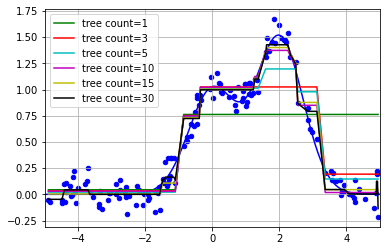

In [108]:
import matplotlib.pyplot as plt
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()



model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()